In [1]:
import os
os.chdir("../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ee
ee.Initialize()
import geemap
print(ee.__version__)

0.1.360


In [2]:
dc = ee.FeatureCollection('TIGER/2018/States').filterMetadata('NAME', 'equals', 'District of Columbia').geometry()

## LANDSAT

In [3]:
dc_ls = (ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
           .filterDate('2010-01-01', '2022-12-31')
           .filterBounds(dc)
           .filter('CLOUD_COVER < 5'))

print(f"there are {dc_ls.size().getInfo()} images in this collection.")

there are 29 images in this collection.


In [4]:
def get_ndvi(img):
    ndvi = img.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return img.addBands(ndvi)

dc_ndvi = dc_ls.map(get_ndvi)

### Get Each Year's NDVI

In [5]:
def get_year_avg(img):
    mean = img.reduceRegion(ee.Reducer.mean(), dc, 30).get('NDVI')
    return img.set('date', img.date().format()).set('mean', mean)

In [6]:
yr_range = ee.List.sequence(2013,2021)
def getYearlyNDVI(y):
    yr_range = ee.Filter.calendarRange(y, y, 'year')
    mean = (dc_ndvi.filter(yr_range)
                   .select('NDVI')
                   .mean()
                   .reduceRegion(ee.Reducer.mean(), dc, 30))
    return mean.set('year', y)

DCYearlyNDVI = yr_range.map(getYearlyNDVI).getInfo()
dc_yr_ndvi = pd.DataFrame(DCYearlyNDVI)
display(dc_yr_ndvi)

,NDVI,year
0,0.255553,2013
1,0.415431,2014
2,0.425041,2015
3,0.329087,2016
4,0.348490,2017
5,0.326505,2018
6,0.429704,2019
7,0.492855,2020
8,0.388530,2021


In [7]:
dc_ls_ts = (dc_ndvi.select("NDVI")
                   .map(get_year_avg)
                   .reduceColumns(ee.Reducer.toList(2), ['date', 'mean'])
                   .values().get(0))
dc_ls_ts_dict = ee.Dictionary(ee.List(dc_ls_ts).flatten())

In [8]:
dc_ndvi_df = pd.DataFrame(dc_ls_ts_dict.getInfo(), index=[0]).T.reset_index()
dc_ndvi_df = dc_ndvi_df.rename({"index": "datetime", 0: "ndvi"}, axis=1)
dc_ndvi_df["datetime"] = pd.to_datetime(dc_ndvi_df["datetime"])
dc_ndvi_by_year = (dc_ndvi_df.set_index("datetime")
                   .groupby(pd.Grouper(freq="Y"))
                   .mean()
                   .reset_index())
display(dc_ndvi_by_year)

,datetime,ndvi
0,2013-12-31,0.255476
1,2014-12-31,0.415412
2,2015-12-31,0.425042
3,2016-12-31,0.329101
4,2017-12-31,0.348467
5,2018-12-31,0.326514
6,2019-12-31,0.429633
7,2020-12-31,0.492992
8,2021-12-31,0.388516


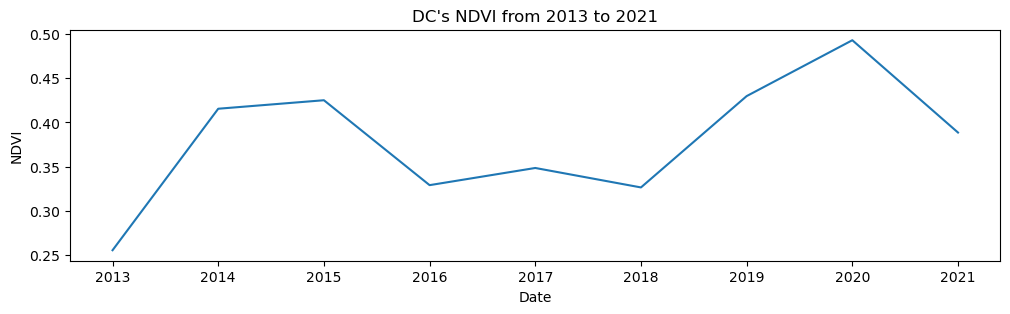

In [9]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.lineplot(x="year", y="NDVI", data=dc_yr_ndvi, ax=ax)
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("DC's NDVI from 2013 to 2021");

In [10]:
Map = geemap.Map(center=(38.897957, -77.036560), zoom=8)
Map.add_basemap('CartoDB.DarkMatter')
vis_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green'], 'bands': ["NDVI"]}
Map.addLayer(dc_ndvi.first(), vis_params, "Landsat-8")
Map

Map(center=[38.897957, -77.03656], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…